Ucitavanje biblioteka

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
print(gpd.__version__)
from folium.plugins import HeatMap, HeatMapWithTime
import itertools

0.9.0


Učitavanje i prikazivanje podataka iz csv datoteke.

In [383]:
file = os.environ.get("RAW_DATA_FILE")
podaci = pd.read_csv(f'{file}')
podaci[['Crash Year','Crash Month','Crash Day','Time of Day','Day of Week','City or Township','Crash: Intersection','Crash: Hit-and-Run','Lighting Conditions','Weather Conditions (2016+)','Speed Limit at Crash Site','Worst Injury in Crash','Party Type','Person Age','Person Gender']].describe()
podaci['City'] = podaci['City or Township'].str.split(':').str[1].str.strip()
podaci.drop("City or Township",axis=1,inplace=True)


In [230]:
podaci.describe(include='object')

,Crash Month,Time of Day,Day of Week,Crash: Intersection,Crash: Hit-and-Run,Lighting Conditions,Weather Conditions (2016+),Speed Limit at Crash Site,Worst Injury in Crash,Party Type,Person Age,Person Gender,City
count,6809,6809,6809,6809,6809,6809,6809,6809,6809,6809,6809,6809,6809
unique,12,25,7,2,2,8,10,15,5,1,87,3,43
top,October,6:00 PM - 7:00 PM,Friday,Not intersection crash,Not hit-and-run,Daylight,Uncoded & errors,25,Possible injury (C),Motor vehicle driver,DOB invalid,Male,Detroit
freq,695,535,1078,3852,4300,3630,4613,2233,2489,6809,2470,2905,4543


In [ ]:
podaci["Worst Injury in Crash"].unique()

informacija o podacima (tipovi, nedostajuće vrijednosti)

In [ ]:
podaci.info()

Provjera neispravnih vrijednosti u setu podataka i ispravljanje istih

In [ ]:

print(podaci['Speed Limit at Crash Site'].unique())
print(podaci['Person Age'].unique())
print(podaci['Weather Conditions (2016+)'].unique())
print(podaci['Lighting Conditions'].unique())

In [381]:
for col in podaci.dtypes[podaci.dtypes == "object"].index:
    print(podaci[col].unique())
    if(podaci[col].str.contains("Uncoded & errors").any()):
        print(podaci[col])


['February' 'March' 'April' 'May' 'June' 'July' 'August' 'September'
 'October' 'November' 'December' 'January']
['9:00 AM - 10:00 AM' '7:00 PM - 8:00 PM' '11:00 AM - 12:00 noon'
 '6:00 PM - 7:00 PM' '2:00 PM - 3:00 PM' '1:00 PM - 2:00 PM'
 '8:00 AM - 9:00 AM' '3:00 PM - 4:00 PM' '8:00 PM - 9:00 PM'
 '10:00 PM - 11:00 PM' '12:00 noon - 1:00 PM' '5:00 PM - 6:00 PM'
 '11:00 PM - 12:00 midnight' '7:00 AM - 8:00 AM' '5:00 AM - 6:00 AM'
 '10:00 AM - 11:00 AM' '9:00 PM - 10:00 PM' '4:00 PM - 5:00 PM'
 '2:00 AM - 3:00 AM' '4:00 AM - 5:00 AM' '1:00 AM - 2:00 AM'
 '12:00 midnight - 1:00 AM' '3:00 AM - 4:00 AM' '6:00 AM - 7:00 AM'
 'Unknown']
['Thursday' 'Sunday' 'Tuesday' 'Friday' 'Wednesday' 'Saturday' 'Monday']
['Not intersection crash' 'Intersection crash']
['Hit-and-run' 'Not hit-and-run']
['Daylight' 'Dark lighted' 'Dusk' 'Dark unlighted' 'Unknown' 'Dawn'
 'Other / unknown']
['Clear' 'Cloudy' 'Snow' 'Rain' 'Unknown' 'Smoke' 'Sleet/hail' 'Fog'
 'Blowing snow' 'None']
['Suspected minor injur

In [384]:
podaci['Speed Limit at Crash Site'] = podaci['Speed Limit at Crash Site'].str.replace('Uncoded & errors', '-1')
podaci['Speed Limit at Crash Site'] = podaci['Speed Limit at Crash Site'].astype('int')

godine_temp = podaci['Person Age'].replace("DOB invalid", np.nan).replace('Less than 1 year old', 0)
godine_mean = pd.to_numeric(godine_temp, errors='coerce').mean()
podaci['Person Age'] = podaci['Person Age'].str.replace('DOB invalid', str(int(godine_mean)))
podaci['Person Age'] = podaci['Person Age'].str.replace('Less than 1 year old', '0')
podaci['Person Age'] = podaci['Person Age'].astype('int')

podaci['Weather Conditions (2016+)'] = podaci['Weather Conditions (2016+)'].str.replace('Uncoded & errors', 'None')

podaci['Lighting Conditions'] = podaci['Lighting Conditions'].str.replace('Uncoded & errors', 'Other / unknown')

podaci['Person Gender'] = podaci['Person Gender'].str.replace('Uncoded & errors', "unknown")

provjera nedostajućih vrijednosti

In [ ]:
print(podaci.isna().sum())

Provjera ponavljajućih vrijednosti

In [117]:
podaci_duplicates = podaci.duplicated()
print(podaci_duplicates.value_counts())

False    6809
dtype: int64


Nakon što je odrađena provjera podataka, možemo krenuti na analizu

In [ ]:
plt.figure(figsize=(18,9))
ax = sns.countplot(x='Crash Year', data=podaci)
#ax.bar_label(ax.containers[0])
plt.title("Ukupno sudara po godini")
plt.show()
plt.clf()

Pokušaj prikaza sudara na mapi

In [ ]:
county_shapefile = gpd.read_file("./data/wayne_county/Cities.shp")

podaci['Car crashes'] = 0

# print(county_shapefile.columns.values.tolist())
# print(podaci.columns.values.tolist())

grupirano = podaci[['Crash Year', 'City or Township']].groupby(['City or Township'])
print(grupirano)



grupirano_po_godinama = pd.DataFrame({'Car crashes' : podaci.groupby( ['City', 'Crash Year'] ).size()}).reset_index().sort_values(['Crash Year','City'])
print(grupirano_po_godinama)

merged_data = county_shapefile.merge(grupirano_po_godinama, left_on='NAME', right_on='City', how='right').sort_values(['Crash Year','City'])
print(merged_data.shape)
print(merged_data.columns.values.tolist())
data_top = merged_data.head(25)
# display 
data_top 


In [ ]:
value='Ecorse'
df2=merged_data.query("City == @value")
print(df2.head(10))

Generiranje mape sa brojem sudara po godinama

In [99]:
geolocator = Nominatim(user_agent="geoapiExercises")

location_dict = {city: [] for city in merged_data["City"].unique()}


for city in merged_data["City"].unique():
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    location_dict[city] = [latitude, longitude]


normalizacija težine u broju nesreća i spremanje svega u format koji traži HeatMapWithTime ( [[[]]] )

In [100]:
min_value = merged_data['Car crashes'].min()
max_value = merged_data['Car crashes'].max()

heatmap_data_time = [[[location_dict[city][0], location_dict[city][1], (merged_data[(merged_data["City"] == city) & (merged_data["Crash Year"] == year)]["Car crashes"].values[0]-min_value)/(max_value-min_value) if len(merged_data[(merged_data["City"] == city) & (merged_data["Crash Year"] == year)]) > 0 else 0]
                      for city in merged_data["City"].unique()] for year in range(2010, 2019) ]


In [ ]:
        
print(np.shape(heatmap_data_time))
godine = merged_data['Crash Year'].unique().tolist()
print(godine)
print(len(godine))

In [112]:
m = folium.Map(location=[42.3314, -83.0458], zoom_start=10.2, #tiles='CartoDB positron'
)
#folium.GeoJson(merged_data).add_to(m)


In [113]:

# Add the heatmap to the map
HeatMapWithTime(heatmap_data_time, 
                auto_play=True,
                index=godine,
                display_index=True,
                gradient={0.3: 'blue', 0.5: 'lime', 0.8: 'orange', 1: 'red'},
                radius=30,
                max_opacity=0.8
                ).add_to(m)

# Save the map as an HTML file
m.save("county_map_heatmap_time.html")


Završena kreirana mapa sa mjestima nesreće

Izrada prediktivnog modela

c:\Users\Domagoj\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


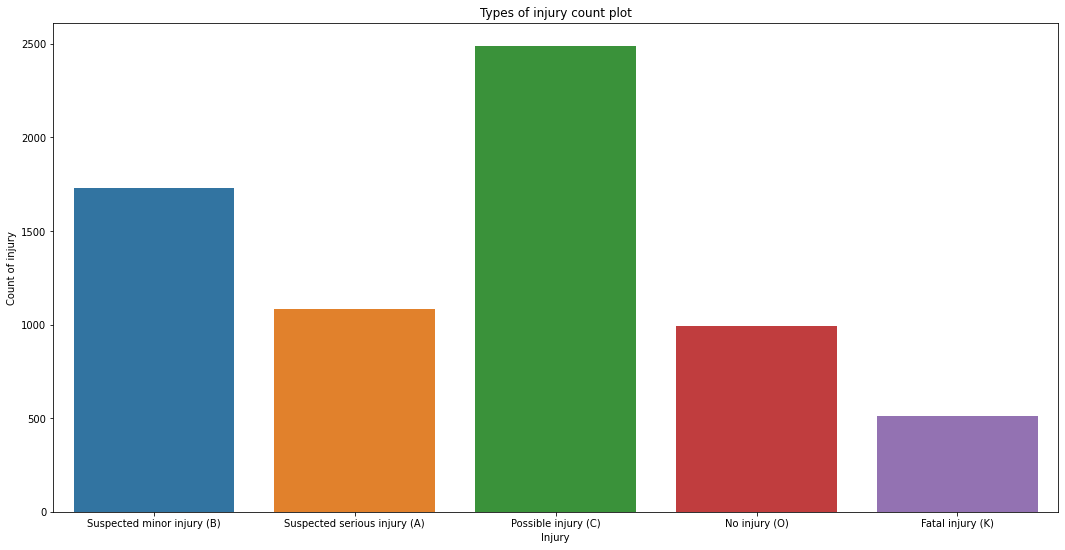

<Figure size 432x288 with 0 Axes>

In [210]:
plt.figure(figsize=(18,9))
sns.countplot(podaci['Worst Injury in Crash'])
plt.xlabel("Injury")
plt.ylabel("Count of injury")
plt.title("Types of injury count plot")
plt.show()
plt.clf()

In [344]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA


In [385]:
data = podaci
#kako bi izbjegli binarnu podjelu kod svih kategorijskih varijabli, brišemo one manje bitne, kako bi sačuvali stvarnu vezu među podacima 
data.drop(columns=["Party Type",'City'],axis=1,inplace=True)

# Encode categorical variables
data = pd.get_dummies(podaci, columns=["Crash Month",'Time of Day','Day of Week',"Crash: Intersection", "Crash: Hit-and-Run",
                    "Lighting Conditions", "Weather Conditions (2016+)", "Person Gender","Worst Injury in Crash"])
data.info()


,Crash Year,Crash Day,Speed Limit at Crash Site,Person Age,Crash Month_April,Crash Month_August,Crash Month_December,Crash Month_February,Crash Month_January,Crash Month_July,...,Weather Conditions (2016+)_Snow,Weather Conditions (2016+)_Unknown,Person Gender_Female,Person Gender_Male,Person Gender_unknown,Worst Injury in Crash_Fatal injury (K),Worst Injury in Crash_No injury (O),Worst Injury in Crash_Possible injury (C),Worst Injury in Crash_Suspected minor injury (B),Worst Injury in Crash_Suspected serious injury (A)
count,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,...,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000,6809.000000
mean,2013.992216,15.384197,31.264650,42.415626,0.065502,0.075195,0.088706,0.070789,0.082097,0.077985,...,0.007637,0.004700,0.292701,0.426641,0.280658,0.075488,0.145836,0.365546,0.254075,0.159054
std,2.597471,8.701025,11.573661,14.015623,0.247427,0.263724,0.284340,0.256490,0.274533,0.268168,...,0.087062,0.068398,0.455036,0.494626,0.449354,0.264197,0.352968,0.481618,0.435372,0.365753
min,2010.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,8.000000,25.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.000000,15.000000,30.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2016.000000,23.000000,35.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,2018.000000,31.000000,70.000000,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [386]:
data.columns.values.tolist()
data.shape
data.info()
#podaci["Worst Injury in Crash"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6809 entries, 0 to 6808
Data columns (total 77 columns):
 #   Column                                              Non-Null Count  Dtype
---  ------                                              --------------  -----
 0   Crash Year                                          6809 non-null   int64
 1   Crash Day                                           6809 non-null   int64
 2   Speed Limit at Crash Site                           6809 non-null   int32
 3   Person Age                                          6809 non-null   int32
 4   Crash Month_April                                   6809 non-null   uint8
 5   Crash Month_August                                  6809 non-null   uint8
 6   Crash Month_December                                6809 non-null   uint8
 7   Crash Month_February                                6809 non-null   uint8
 8   Crash Month_January                                 6809 non-null   uint8
 9   Crash Month_July   

podjela podataka za trening i testiranje

In [387]:
X = data.drop(columns=['Worst Injury in Crash_Fatal injury (K)',
 'Worst Injury in Crash_No injury (O)',
 'Worst Injury in Crash_Possible injury (C)',
 'Worst Injury in Crash_Suspected minor injury (B)',
 'Worst Injury in Crash_Suspected serious injury (A)'], axis=1)
y = data.iloc[:, -5:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y

,Worst Injury in Crash_Fatal injury (K),Worst Injury in Crash_No injury (O),Worst Injury in Crash_Possible injury (C),Worst Injury in Crash_Suspected minor injury (B),Worst Injury in Crash_Suspected serious injury (A)
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
6804,1,0,0,0,0
6805,0,0,0,1,0
6806,0,0,1,0,0
6807,0,0,1,0,0


In [345]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

pokusaj sa NN

In [388]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Odabir modela za učenje

In [352]:
# Import the linear regression model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [348]:
# Create an instance of the model
model = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_split= 2)

In [391]:
model = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', solver='adam',max_iter=1000)

In [392]:
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.2305433186490455

In [296]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [393]:
y_pred = model.predict(X_test)

In [394]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [395]:
print("Accuracy: {:.2f}".format(acc))
print("Precision: {:.2f}".format(prec))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.23
Precision: 0.32
Recall: 0.32
F1 Score: 0.32


In [334]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Create an instance of the model
model = RandomForestClassifier(random_state=0)

# Create an instance of GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best score:  0.10391184573002754
